# PBO on LQR

## Define paramters

In [1]:
%load_ext autoreload
%autoreload 2

import jax

# keys
seed = 10
key = jax.random.PRNGKey(seed)
env_key, key = jax.random.split(key)
shuffle_key, q_network_key, random_weights_key, pbo_network_key = jax.random.split(key, 4)

# Sample collection
max_discrete_state = 5
n_discrete_states = 7
max_discrete_action = 5
n_discrete_actions = 7
n_samples = n_discrete_states * n_discrete_actions

# Weights collection
n_weights = 100
weights_filtering = True

# Q function
action_range_on_max = max_discrete_action
n_actions_on_max = 50

# Trainings
training_steps = 200
fitting_steps = 20
max_bellman_iterations = 5
add_infinity = True
batch_size_weights = n_weights
batch_size_samples = n_samples
learning_rate = {"first": 0.01, "last": 0.00005, "duration": training_steps * fitting_steps * n_samples // batch_size_samples}
learning_rate_optimal_linear = {"first": 0.01, "last": 0.00005, "duration": training_steps * fitting_steps}

# Visualisation
plot_freq = 20
n_iterations = max_bellman_iterations
sleeping_time = 0

## Define environment

In [2]:
import numpy as np

from pbo.environment.linear_quadratic import LinearQuadraticEnv


discrete_states = np.linspace(-max_discrete_state, max_discrete_state, n_discrete_states)
state_box_half_size = max_discrete_state / n_discrete_states
discrete_states_boxes = np.linspace(
    -max_discrete_state - state_box_half_size, max_discrete_state + state_box_half_size, n_discrete_states + 1
)

discrete_actions = np.linspace(-max_discrete_action, max_discrete_action, n_discrete_actions)
action_box_half_size = max_discrete_action / n_discrete_actions
discrete_actions_boxes = np.linspace(
    -max_discrete_action - action_box_half_size, max_discrete_action + action_box_half_size, n_discrete_actions + 1
)

env = LinearQuadraticEnv(env_key, max_init_state=max_discrete_state)

Transition: s' = As + Ba
Transition: s' = 0.6187217235565186s + 0.8172223567962646a
Reward: Qs² + Ra² + 2 Ssa
Reward: -0.9376579523086548s² + -0.9282257556915283a² + 0.13357019424438477sa


## Collect samples

### Samples on the mesh

In [3]:
import jax.numpy as jnp

from pbo.sample_collection.replay_buffer import ReplayBuffer


n_samples = n_discrete_states * n_discrete_actions
replay_buffer = ReplayBuffer()

for state in discrete_states:
    for action in discrete_actions:
        env.reset(jnp.array([state]))
        next_state, reward, absorbing, _ = env.step(jnp.array([action]))

        replay_buffer.add(jnp.array([state]), jnp.array([action]), reward, next_state, absorbing)

replay_buffer.cast_to_jax_array()

### Visualize samples

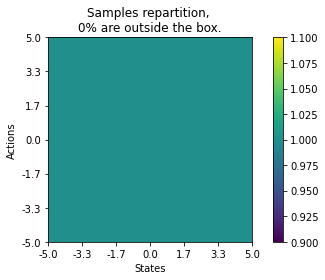

In [4]:
from pbo.sample_collection.count_samples import count_samples
from pbo.utils.two_dimesions_mesh import TwoDimesionsMesh


samples_count, n_outside_boxes, _ = count_samples(replay_buffer.states, replay_buffer.actions, discrete_states_boxes, discrete_actions_boxes, replay_buffer.rewards)
samples_visu_mesh = TwoDimesionsMesh(discrete_states, discrete_actions, sleeping_time=0)

samples_visu_mesh.set_values(samples_count, zeros_to_nan=True)
samples_visu_mesh.show(
    f"Samples repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box."
)


## Optimal Q function

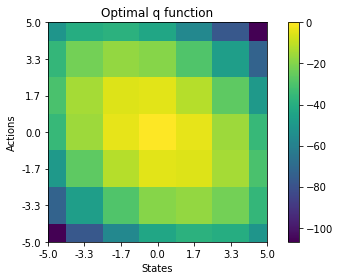

In [5]:
optimal_q = env.optimal_Q_mesh(discrete_states, discrete_actions)

q_visu_mesh = TwoDimesionsMesh(discrete_states, discrete_actions, sleeping_time)

q_visu_mesh.set_values(optimal_q)
q_visu_mesh.show("Optimal q function")

## Build q network

In [6]:
from pbo.networks.learnable_q import LQRQ


q = LQRQ(
    state_dim=1,
    action_dim=1,
    n_actions_on_max=n_actions_on_max,
    action_range_on_max=action_range_on_max,
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=random_weights_key,
    learning_rate=None,
    zero_initializer=False,
)

## Collect weights

In [7]:
from pbo.weights_collection.weights_buffer import WeightsBuffer


weights_buffer = WeightsBuffer()

while len(weights_buffer) < n_weights:
    weights = q.random_init_weights()
    if not weights_filtering or q.to_params(weights)["LQRQNet"]["m"] < 0:
        weights_buffer.add(weights)

weights_buffer.cast_to_jax_array()

## Train the optimal linear PBO

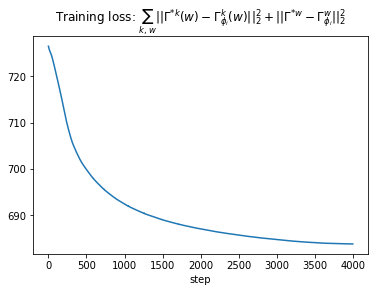

In [8]:
import matplotlib.pyplot as plt

from pbo.networks.learnable_pbo import LinearPBOOnWeights
from pbo.networks.optimal_pbo import OptimalLQRPBO
from pbo.weights_collection.dataloader import WeightsDataLoader


data_loader_weights = WeightsDataLoader(weights_buffer, batch_size_weights, shuffle_key)

pbo_optimal = OptimalLQRPBO(q, max_bellman_iterations, add_infinity, env.A[0, 0], env.B[0, 0], env.Q[0, 0], env.R[0, 0], env.S[0, 0], env.P[0, 0])
pbo_on_weights = LinearPBOOnWeights(q, max_bellman_iterations, add_infinity, pbo_network_key, learning_rate_optimal_linear, pbo_optimal)
importance_iteration = jnp.ones(max_bellman_iterations + 1)

l2_losses = np.ones(training_steps * fitting_steps) * np.nan

for step in range(training_steps * fitting_steps):
    cumulative_l2_loss = 0

    data_loader_weights.shuffle()
    for batch_weights in data_loader_weights:
        pbo_on_weights.params, pbo_on_weights.optimizer_state, l2_loss = pbo_on_weights.learn_on_batch_on_weights(
            pbo_on_weights.params, pbo_on_weights.optimizer_state, batch_weights, importance_iteration
        )
        cumulative_l2_loss += l2_loss

    l2_losses[step] = cumulative_l2_loss


plt.plot(l2_losses)
plt.xlabel("step")
plt.title("Training loss: " + r"$\sum_{k, w} || \Gamma^{* k}(w) - \Gamma_{\phi_i}^k(w) ||_2^2 + || \Gamma^{* w} - \Gamma_{\phi_i}^w ||_2^2$")
plt.show()

## Train the linear PBO

In [9]:
from pbo.utils.weights_iterator import WeightsIterator
from pbo.networks.learnable_pbo import LinearPBO
from pbo.sample_collection.dataloader import SampleDataLoader


data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
data_loader_weights = WeightsDataLoader(weights_buffer, batch_size_weights, shuffle_key)

pbo_optimal = OptimalLQRPBO(q, max_bellman_iterations, add_infinity, env.A[0, 0], env.B[0, 0], env.Q[0, 0], env.R[0, 0], env.S[0, 0], env.P[0, 0])
pbo = LinearPBO(q, max_bellman_iterations, add_infinity, pbo_network_key, learning_rate)
importance_iteration = jnp.ones(max_bellman_iterations + 1)

weights_iterator = WeightsIterator(
    pbo, pbo_optimal, pbo_on_weights, data_loader_weights.weights, n_iterations, add_infinity, 0
)
l2_losses = np.ones((training_steps, fitting_steps)) * np.nan


for training_step in range(training_steps):
    params_target = pbo.params

    for fitting_step in range(fitting_steps):
        cumulative_l2_loss = 0

        data_loader_weights.shuffle()
        for batch_weights in data_loader_weights:
            data_loader_samples.shuffle()
            for batch_samples in data_loader_samples:
                pbo.params, pbo.optimizer_state, l2_loss = pbo.learn_on_batch(
                    pbo.params, params_target, pbo.optimizer_state, batch_weights, batch_samples, importance_iteration
                )
                cumulative_l2_loss += l2_loss

        l2_losses[training_step, fitting_step] = cumulative_l2_loss
    
    if (training_step + 1) % plot_freq == 0:
        weights_iterator.iterate_on_params(pbo.params, pbo.fixed_point(pbo.params))
        weights_iterator.show(
            f"Iterations on the initial weights[0] at training step: {training_step}, \nl2 loss: {str(np.round(l2_losses[training_step, -1], 2))}"
        )


for training_step in range(0, training_steps, max(training_steps // 5, 1)):
    plt.plot(l2_losses[training_step], label=f"Training step {training_step + 1}")

plt.legend()
plt.xlabel("fitting step")
plt.title("Training losses: " + r"$\sum_{k, w} \left(\Gamma^*Q_{\Gamma_{\phi_{i - 1}}^{k - 1}(w)} - Q_{\Gamma_{\phi_i}^k(w)} \right)^2 + \left(\Gamma^*Q_{\Gamma_{\phi_i}^w} - Q_{\Gamma_{\phi_i}^w} \right)^2$")
plt.show()
print(f"Error at infinity: {np.sqrt(np.square(pbo_optimal.fixed_point() - pbo.fixed_point(pbo.params)).mean())}")

TypeError: __init__() missing 1 required positional argument: 'sleeping_time'

## Visualize iterations on weights

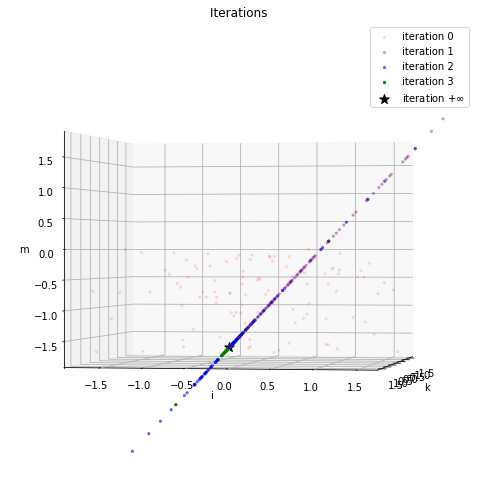

In [ ]:
weights_iterator.visualize(pbo_optimal, optimal=True)

Contracting facteur PBO 1.0194036


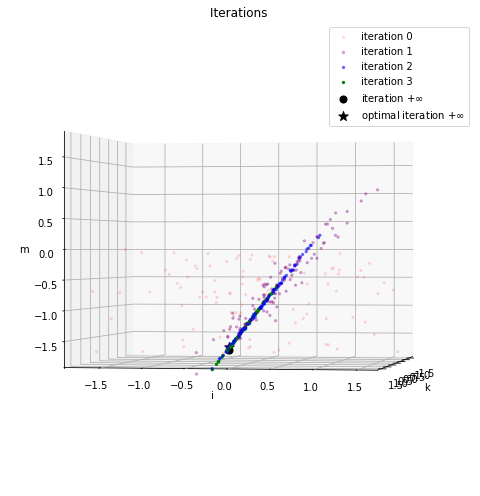

In [ ]:
print("Contracting facteur PBO", pbo.contracting_factor())
weights_iterator.visualize(pbo, optimal=False)

Contracting facteur PBO on weights 25.242268


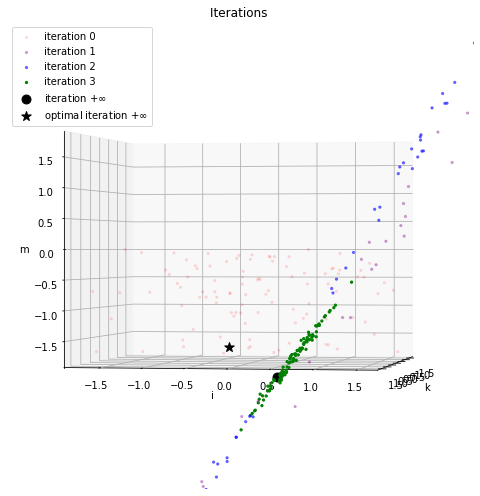

In [ ]:
print("Contracting facteur PBO on weights", pbo_on_weights.contracting_factor())
weights_iterator.visualize(pbo_on_weights, optimal=False)